In [4]:
%load_ext autoreload
%autoreload 2
import numpy
import pandas
import io
import uuid
import psycopg.sql
import pyarrow
import pyarrow.parquet

import jobqueue
from jobqueue.connection_manager import ConnectionManager



import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime

pd.options.display.max_seq_items = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# from enum import Enum, auto

# class ColumnSource(Enum):
#     run_column=auto()
#     run
#     run_column=auto()
#     run_column=auto()
#     run_column=auto()
#     run_column=auto()

from dataclasses import dataclass



@dataclass
class Column:
    name : str
    pandas_type : str


In [32]:
def flatten_json(json_obj, parent_key='', separator='_'):
    flattened = {}
    for key, value in json_obj.items():
        new_key = f"{parent_key}{separator}{key}" if parent_key else key
        if isinstance(value, dict):
            flattened.update(flatten_json(value, new_key, separator=separator))
        else:
            flattened[new_key] = value
    return flattened


experiment_id = 0
run_command = {}
credentials = jobqueue.load_credentials('dmp')
with ConnectionManager(credentials) as connection:
    with connection.cursor(binary=True) as cursor:
        query = psycopg.sql.SQL("""
SELECT
    d.command,
    h.history history,
    h.experiment_id,
    e.by_epoch
FROM
    run_status s,
    run_data d,
    history h,
    experiment2 e
WHERE TRUE
    AND s.id = d.id
    AND h.id = s.id
    AND s.id = '7368b774-107b-482a-b44f-b8cc05de14ea'
    AND e.experiment_id = h.experiment_id
LIMIT 1;
""")

        cursor.execute(query, binary=True)
        row = cursor.fetchone()
        with io.BytesIO(row[1]) as buffer:
            history = pyarrow.parquet.read_table(
                pyarrow.PythonFile(buffer, mode='r')).to_pandas()

        run_command = row[0]
        flat = flatten_json(row[0])
        for k, v in flat.items():
            if isinstance(v, list):
                continue
            history[k] = v

        experiment_id = row[2]

        with io.BytesIO(row[3]) as buffer:
            by_epoch = pyarrow.parquet.read_table(
                pyarrow.PythonFile(buffer, mode='r')).to_pandas()


history.describe()
history

/tmp/ipykernel_7443/482533585.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[k] = v
/tmp/ipykernel_7443/482533585.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[k] = v
/tmp/ipykernel_7443/482533585.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[k] = v
/tmp/ip

,fit_number,epoch,epoch_startms_ms,test_ms,trainms_ms,seed_number,fit_epoch,trained_loss,train_loss,free_parameter_count,...,experiment_pruning_rewind_optimizer,experiment_pruning_max_epochs_per_iteration,experiment_optimizer_class,experiment_optimizer_learning_rate,experiment_precision,experiment_early_stopping_class,experiment_early_stopping_monitor,experiment_early_stopping_patience,experiment_early_stopping_min_delta,experiment_early_stopping_restore_best_weights
0,0,3,NaN,NaN,NaN,0,3,2.647772,2.647772,61706,...,True,32,Adam,0.0012,float32,DMPEarlyStopping,val_loss,32,0,True
1,0,4,1.697947e+12,308.0,6172.0,0,4,0.070298,0.172972,61706,...,True,32,Adam,0.0012,float32,DMPEarlyStopping,val_loss,32,0,True
2,0,5,1.697947e+12,309.0,1744.0,0,5,0.040371,0.058938,61706,...,True,32,Adam,0.0012,float32,DMPEarlyStopping,val_loss,32,0,True
3,0,6,1.697947e+12,308.0,1743.0,0,6,0.032035,0.041800,61706,...,True,32,Adam,0.0012,float32,DMPEarlyStopping,val_loss,32,0,True
4,0,7,1.697947e+12,309.0,1772.0,0,7,0.021408,0.030861,61706,...,True,32,Adam,0.0012,float32,DMPEarlyStopping,val_loss,32,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,21,62,1.697962e+12,876.0,13057.0,0,59,0.067835,0.068896,61706,...,True,32,Adam,0.0012,float32,DMPEarlyStopping,val_loss,32,0,True
722,21,63,1.697962e+12,873.0,13047.0,0,60,0.067519,0.068539,61706,...,True,32,Adam,0.0012,float32,DMPEarlyStopping,val_loss,32,0,True
723,21,64,1.697962e+12,873.0,13058.0,0,61,0.067227,0.068187,61706,...,True,32,Adam,0.0012,float32,DMPEarlyStopping,val_loss,32,0,True
724,21,65,1.697962e+12,875.0,13057.0,0,62,0.066946,0.067851,61706,...,True,32,Adam,0.0012,float32,DMPEarlyStopping,val_loss,32,0,True


In [33]:
print((history['epoch'] - history['fit_epoch']).to_string())

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
30     0
31     0
32     0
33     3
34     3
35     3
36     3
37     3
38     3
39     3
40     3
41     3
42     3
43     3
44     3
45     3
46     3
47     3
48     3
49     3
50     3
51     3
52     3
53     3
54     3
55     3
56     3
57     3
58     3
59     3
60     3
61     3
62     3
63     3
64     3
65     3
66     3
67     3
68     3
69     3
70     3
71     3
72     3
73     3
74     3
75     3
76     3
77     3
78     3
79     3
80     3
81     3
82     3
83     3
84     3
85     3
86     3
87     3
88     3
89     3
90     3
91     3
92     3
93     3
94     3
95     3
96     3
97     3
98     3
99     3
100    3
101    3
102    3
103    3
104    3
105    3
106    3
107    3
108    3
109    3
110    3
1

In [11]:
by_epoch.columns

Index(['epoch', 'count'], dtype='object')

In [12]:
history['experiment_pruning_method_pruning_rate'].loc[0]

0.19999999999999996

In [13]:
from pprint import pprint
pprint(run_command)

{'experiment': {'data': {'batch': 'lmc_mnist_lenet_2',
                         'data_set_size': 70000,
                         'input_shape': [28, 28, 1],
                         'lmc': True,
                         'ml_task': 'classification',
                         'model_family': 'lenet',
                         'model_name': 'lenet_relu',
                         'network_description': {},
                         'num_free_parameters': 61706,
                         'output_shape': [10],
                         'test_set_size': 10000,
                         'train_set_size': 56500,
                         'validation_set_size': 3500},
                'dataset': {'label_noise': 0.0,
                            'method': 'shuffled_train_test_split',
                            'name': 'mnist',
                            'source': 'keras',
                            'test_split': 0.14285714285714285,
                            'type': 'DatasetSpec',
                   

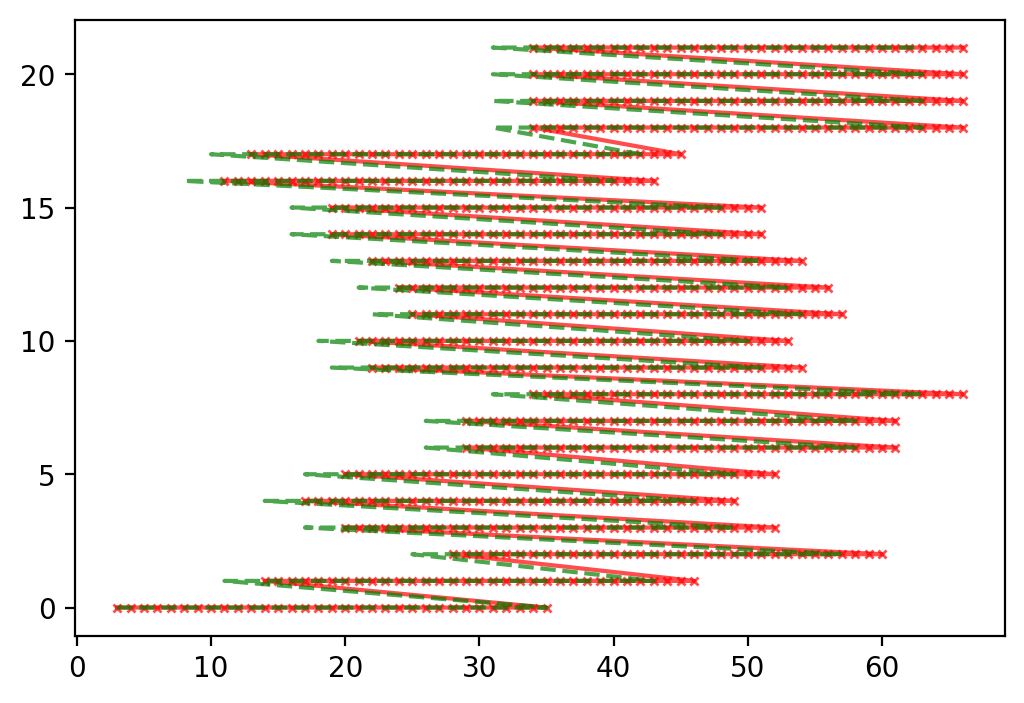

In [34]:
fig = plt.figure(dpi=200, figsize=(6,4))

# plt.semilogy(history['epoch'], history['test_loss'], '-og', markersize=3.0, alpha=.7)
plt.plot(history['epoch'], history['fit_number'], '-xr', markersize=3.0, alpha=.7)
plt.plot(history['fit_epoch'], history['fit_number'], '--g', markersize=3.0, alpha=.7)


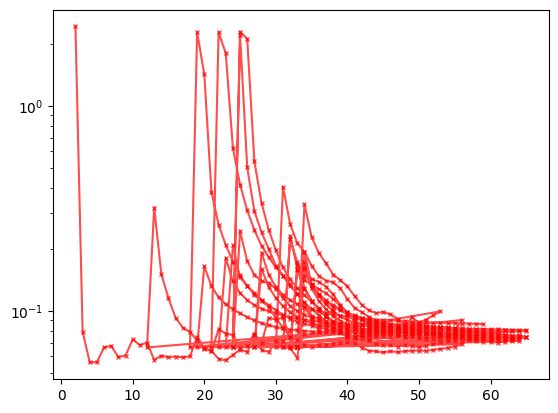

In [23]:
plt.semilogy(history['epoch'], history['test_loss'], '-xr', markersize=3.0, alpha=.7)

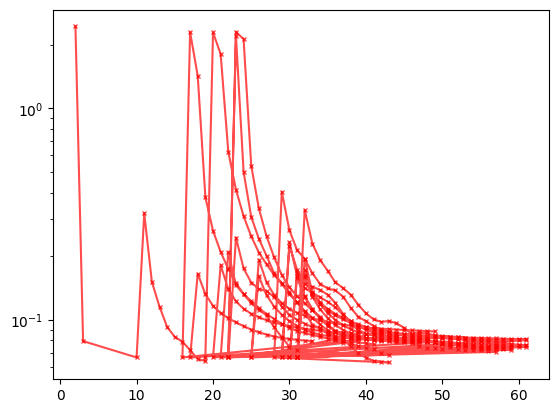

In [25]:
retained= history.loc[history['retained'] == True]
plt.semilogy(retained['fit_epoch'], retained['test_loss'], '-xr', markersize=3.0, alpha=.7)

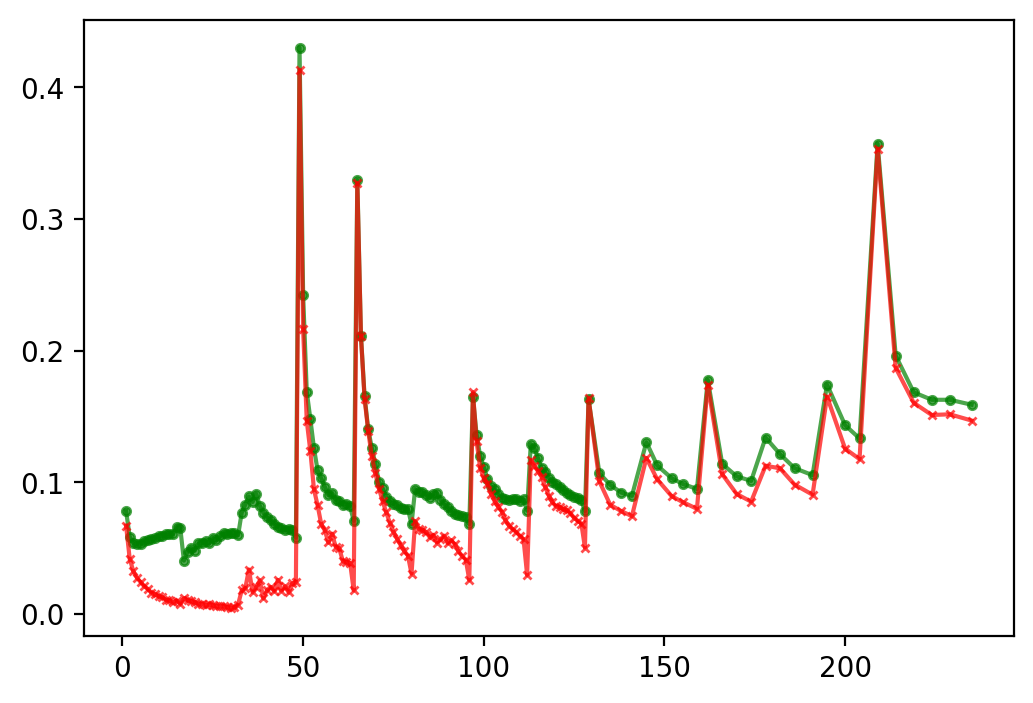

In [ ]:
fig = plt.figure(dpi=200, figsize=(6,4))
plt.plot(by_epoch['epoch'], by_epoch['test_loss_quantile_50'], '-og', markersize=3.0, alpha=.7)
plt.plot(by_epoch['epoch'], by_epoch['trained_loss_quantile_50'], '-xr', markersize=3.0, alpha=.7)

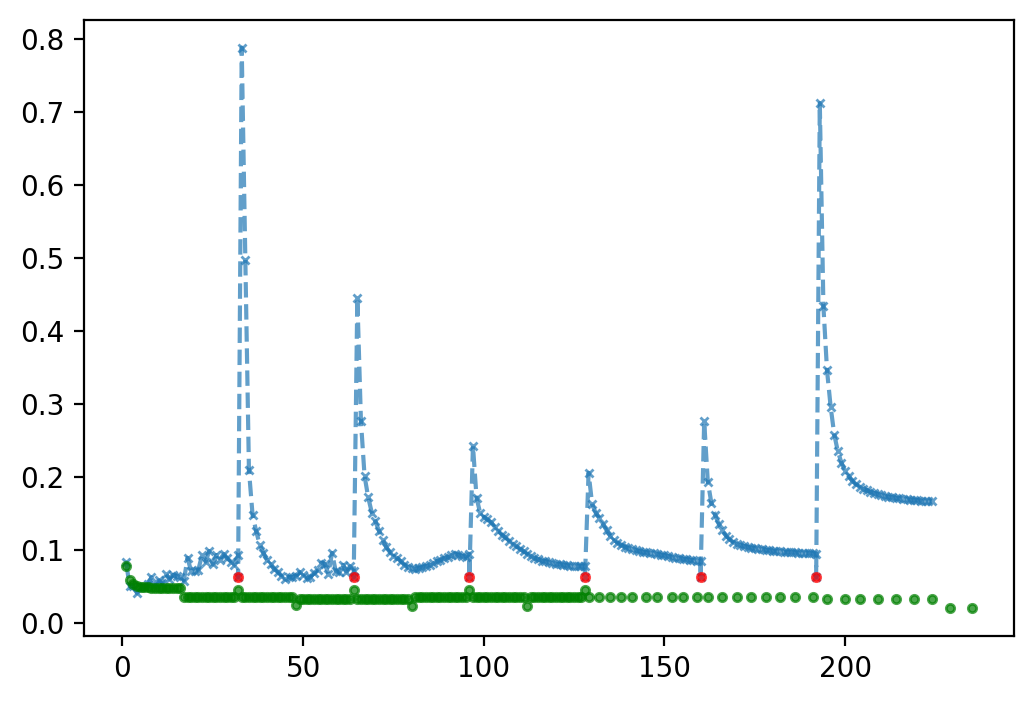

In [ ]:
fig = plt.figure(dpi=200, figsize=(6,4))

plt.plot(history['epoch'], history['test_loss'], '--x', markersize=3.0, alpha=.7)
new_iterations = history[history['model_epoch'] == 0]
plt.plot(by_epoch['epoch'], by_epoch['test_loss_cmin_quantile_50'], 'og', markersize=3.0, alpha=.7)

plt.plot(new_iterations['epoch'], new_iterations['test_loss'], 'or', markersize=3.0, alpha=.7)


In [ ]:
history.columns

Index(['test_loss', 'trained_categorical_crossentropy', 'trained_accuracy',
       'train_categorical_crossentropy', 'free_parameter_count',
       'train_accuracy', 'retained', 'validation_categorical_crossentropy',
       'masked_parameter_count', 'validation_accuracy', 'trainms_ms',
       'trained_ms', 'train_loss', 'test_ms', 'model_epoch', 'epoch',
       'validation_loss', 'seed_number', 'test_accuracy', 'model_number',
       'test_categorical_crossentropy', 'trained_loss', 'epoch_startms_ms'],
      dtype='object')

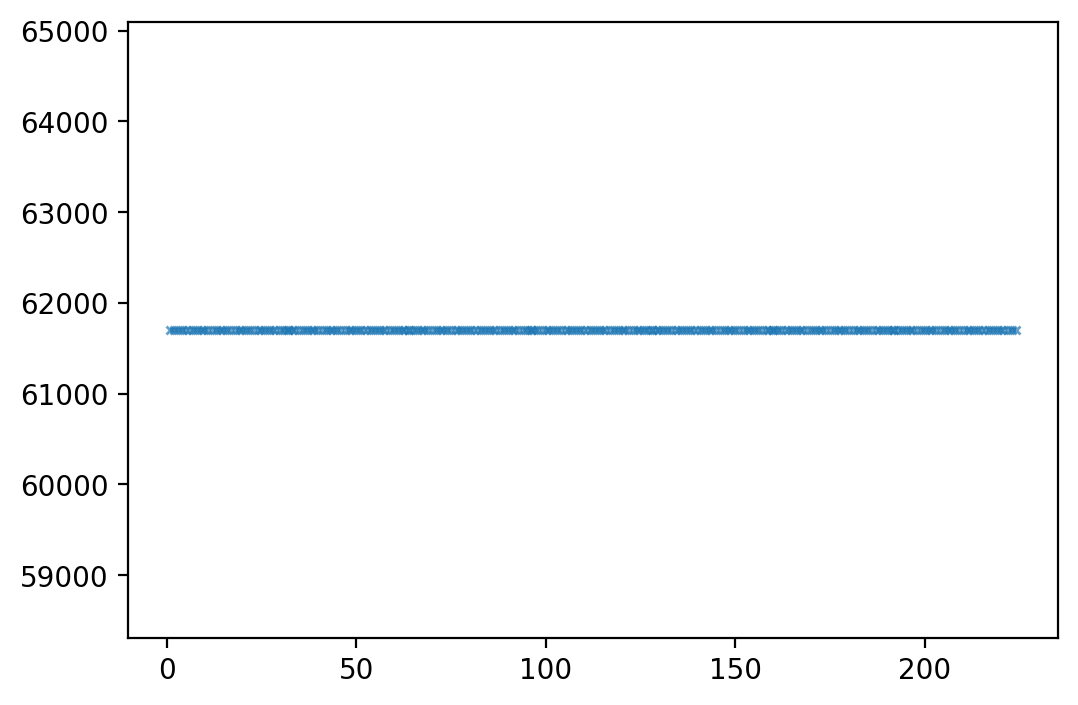

In [ ]:
fig = plt.figure(dpi=200, figsize=(6,4))

plt.plot(history['epoch'], history['free_parameter_count'], '--x', markersize=3.0, alpha=.7)


In [ ]:

credentials = jobqueue.load_credentials('dmp')
with ConnectionManager(credentials) as connection:
    with connection.cursor(binary=True) as cursor:
        query = psycopg.sql.SQL("""
SELECT
    by_epoch
FROM
    experiment2 e
WHERE TRUE
    AND e.experiment_id = 'b0d415cf-f228-c439-0480-3337c543c2e4'
LIMIT 1;
""")

        cursor.execute(query, binary=True)
        row = cursor.fetchone()
        with io.BytesIO(row[0]) as buffer:
            by_epoch = pyarrow.parquet.read_table(
                pyarrow.PythonFile(buffer, mode='r')).to_pandas()


by_epoch.describe()
by_epoch

,epoch,count,model_epoch_quantile_0,model_epoch_quantile_25,model_epoch_quantile_50,model_epoch_quantile_75,model_epoch_quantile_100,trained_categorical_crossentropy_quantile_0,trained_categorical_crossentropy_quantile_25,trained_categorical_crossentropy_quantile_50,...,test_accuracy_cmax_quantile_0,test_accuracy_cmax_quantile_25,test_accuracy_cmax_quantile_50,test_accuracy_cmax_quantile_75,test_accuracy_cmax_quantile_100,validation_accuracy_cmax_quantile_0,validation_accuracy_cmax_quantile_25,validation_accuracy_cmax_quantile_50,validation_accuracy_cmax_quantile_75,validation_accuracy_cmax_quantile_100
0,1,8,1.0,1.0,1.0,1.0,1.0,0.060437,0.061399,0.066523,...,0.9734,0.973925,0.97625,0.977575,0.9798,0.974000,0.975571,0.976571,0.977286,0.980571
1,2,8,2.0,2.0,2.0,2.0,2.0,0.039023,0.039946,0.041580,...,0.9762,0.980350,0.98225,0.982875,0.9843,0.980000,0.981071,0.981429,0.982143,0.985143
2,3,8,3.0,3.0,3.0,3.0,3.0,0.028624,0.030501,0.035552,...,0.9810,0.981500,0.98280,0.983900,0.9866,0.980857,0.981643,0.983000,0.984071,0.989429
3,4,8,4.0,4.0,4.0,4.0,4.0,0.019772,0.025258,0.027370,...,0.9812,0.981675,0.98450,0.985625,0.9885,0.980857,0.983214,0.983857,0.986857,0.989429
4,5,8,5.0,5.0,5.0,5.0,5.0,0.017522,0.022112,0.024034,...,0.9816,0.984450,0.98495,0.985650,0.9885,0.980857,0.983929,0.985429,0.987071,0.989429
5,6,8,6.0,6.0,6.0,6.0,6.0,0.016902,0.019114,0.019577,...,0.9819,0.984825,0.98520,0.986550,0.9885,0.984000,0.984786,0.985571,0.987071,0.989429
6,7,8,7.0,7.0,7.0,7.0,7.0,0.014243,0.016146,0.017878,...,0.9851,0.985725,0.98655,0.988050,0.9885,0.984000,0.985143,0.986000,0.987214,0.989429
7,8,8,8.0,8.0,8.0,8.0,8.0,0.010488,0.012256,0.017983,...,0.9851,0.986250,0.98745,0.988500,0.9888,0.984000,0.985143,0.986143,0.987214,0.989714
8,9,8,9.0,9.0,9.0,9.0,9.0,0.010544,0.011973,0.016272,...,0.9851,0.986250,0.98775,0.988500,0.9891,0.984000,0.985143,0.986143,0.987214,0.990000
9,10,8,10.0,10.0,10.0,10.0,10.0,0.008422,0.011188,0.012371,...,0.9859,0.986800,0.98775,0.988500,0.9897,0.984000,0.985143,0.986714,0.988643,0.990000


In [ ]:
df.columns

Index(['experiment_id', 'old_experiment_id', 'experiment_attrs', 'run_id',
       'job_id', 'slurm_job_id', 'run_timestamp', 'seed', 'task_version',
       'num_nodes',
       ...
       'precision', 'worker_id', 'record_model', 'record_times',
       'python_version', 'record_metrics', 'tensorflow_version',
       'tensorflow_strategy', 'record_post_training_metrics',
       'make_batch_optimizer_butter_growth_eagle_gpu_1'],
      dtype='object', length=105)

In [ ]:
df['run_history'].iloc[0]['train_loss']


0      1.247540
1      0.898057
2      0.847315
3      0.850349
4      0.847144
         ...   
145    0.225552
146    0.213775
147    0.213580
148    0.213284
149    0.210847
Name: train_loss, Length: 150, dtype: float32

In [ ]:
run_df = df['run_history'].iloc[0]
run_df['trained_loss'] - run_df['train_loss']

0      0.000000
1     -0.047707
2      0.003034
3      0.000000
4     -0.001494
         ...   
145    0.026551
146   -0.015600
147   -0.015426
148   -0.008199
149    0.011152
Length: 150, dtype: float32